Use the autoreload to make sure the latest version of the module is used.
There are 3 configuration options that can be set:

> ```%autoreload 0 ```: Disables the auto-reloading. This is the default setting.

> ```%autoreload 1``` :Will only auto-reload modules that were imported using the %aimport function (e.g %aimport my_module). It’s a good option if you want to specifically auto-reload only a selected module.

> ```%autoreload 2``` : auto-reload all the modules. Great way to make writing and testing your modules much easier.

In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
""" Grid as Pipe is used to generate LGR grid for later CO2 simulation in pflotran or Eclipse
"""
%matplotlib inline

import os
import json
import yaml

from dataclasses import dataclass

import numpy as np
from matplotlib import pyplot as plt


In [123]:
#import rips 

from ecl.grid import EclGrid
from ecl.eclfile import EclInitFile

In [124]:
import sys

sys.path.append('../')

In [125]:
# 
from libs.geometry import (
    make_stat_3d_main,
    generate_LGR_grids,
)

from libs.models import GaPModel

from libs.geometry.bbox_pipe_with_oph_sec import bbox_for_pipe_with_oph_sec
from libs.geometry.bbox_barrier import bbox_for_barrier
from libs.geometry.bbox_cement_bond import bbox_for_cement_bond

from libs.carfin import build_grdecl

from libs.plotting import (
    pipe_plotter, 
    barrier_plotter,
    ob_reservoir_plotter,
)

In [126]:
!pwd

/scratch/SCS/hzh/SCREEN/src/GaP/notebooks


In [127]:
# input_path='/scratch/SCS/eim/SMEAHEIA'

config_file = './smeaheia.yaml'


In [128]:
# load configuration file
with open(config_file, "r") as f:
    config = yaml.safe_load(f)

# dict => pydantic model
gap = GaPModel(**config)

In [129]:
# pretty print
# print(json.dumps(gap.model_dump(mode='json'), indent=2))

In [130]:
# only for convenience
spec = gap.spec

In [131]:
# 0.1 before sorting
# casings
casings = spec.casings
# barriers
barriers = spec.barriers

# # for qc
# print(casings)

# 0.2 after sorting
# casings
casings.sort(reverse=True, key=lambda elem: elem.ID)
# barriers
barriers.sort(reverse=True, key=lambda elem: elem.ID)

In [132]:
# # for qc
# for casing in casings:
#     casing_json = casing.model_dump()
#     print(json.dumps(casing_json, indent=2))

In [133]:
# input simulation case
input_folder = spec.sim_case.folder
simcase = os.path.join(input_folder, spec.sim_case.filename)

# output LGR name
output_folder = spec.lgr_out.folder
LGR_NAME = spec.lgr_out.filename

# minimum dz value for overburden
MIN_DZ_OB = spec.defaults.mindz_ob

## Grid (coarse) information

In [134]:
####### 0. Initialization ######

################### 0.1 Loading the model ################
# Eclipse grid
grid = EclGrid(simcase + ".EGRID") 
init = EclInitFile(grid, simcase + ".INIT")
#init = EclGrid(simcase + ".INIT")

In [135]:
# dimension of coarse grid
nx, ny, nz, _ = grid.get_dims()
nx, ny, nz

(20, 20, 82)

In [136]:
############## 0.2 Main grid input data ##################

main_grd_i = nx//2
main_grd_j = ny//2

main_grd_min_k = 1
main_grd_max_k = nz

In [137]:
main_grd_i, main_grd_j, main_grd_min_k, main_grd_max_k

(10, 10, 1, 82)

In [138]:
# dx and dy (coarse grid) at well location
main_grd_dx =  make_stat_3d_main(grid, init, 'DX', 0)[main_grd_i-1, main_grd_j-1, main_grd_min_k-1]       # 656.168 ft 

main_grd_dx

200.0

In [139]:
# list of DZs (coarse grid)
main_DZ = make_stat_3d_main(grid, init, 'DZ', 0)[main_grd_i-1, main_grd_j-1, (main_grd_min_k-1):main_grd_max_k]

main_DZ

array([308., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.])

In [140]:
main_DEPTH = make_stat_3d_main(grid, init, 'DEPTH', 0)[main_grd_i-1, main_grd_j-1, (main_grd_min_k-1):main_grd_max_k]
main_DEPTH

array([ 158. ,  362. ,  462. ,  562. ,  662. ,  762. ,  862. ,  962. ,
       1062. , 1162. , 1214.5, 1219.5, 1224.5, 1229.5, 1234.5, 1239.5,
       1244.5, 1249.5, 1254.5, 1259.5, 1264.5, 1269.5, 1274.5, 1279.5,
       1284.5, 1289.5, 1294.5, 1299.5, 1304.5, 1309.5, 1314.5, 1319.5,
       1324.5, 1329.5, 1334.5, 1339.5, 1344.5, 1349.5, 1354.5, 1359.5,
       1364.5, 1369.5, 1374.5, 1379.5, 1384.5, 1389.5, 1394.5, 1399.5,
       1404.5, 1409.5, 1414.5, 1419.5, 1424.5, 1429.5, 1434.5, 1439.5,
       1444.5, 1449.5, 1454.5, 1459.5, 1464.5, 1469.5, 1474.5, 1479.5,
       1484.5, 1489.5, 1494.5, 1499.5, 1504.5, 1509.5, 1514.5, 1519.5,
       1527. , 1537. , 1547. , 1557. , 1567. , 1577. , 1587. , 1597. ,
       1607. , 1617. ])

In [141]:
main_DEPTH[0], 0.5*main_DZ[0]

(158.0, 154.0)

In [142]:
# reference depth where LGR (legacy well) starts
ref_depth = main_DEPTH[0] - 0.5*main_DZ[0]
ref_depth

4.0

In [143]:
# assume any layers that has DZ > 10 will be overburden layers
DZ0 = 10.0

In [144]:
# number of layer in overburden 
no_of_layers_in_OB = np.count_nonzero(main_DZ[main_DZ > DZ0])
no_of_layers_in_OB

10

## LGR grids

In [145]:
################# 2. generate LGR grids ##################################


print ('Generate LGR grid...') 

Generate LGR grid...


In [146]:
main_grd_min_k, main_grd_max_k

(1, 82)

In [147]:
# number of OB layers
aa = no_of_layers_in_OB - main_grd_min_k + 1

# number of reservoir layers
bb = main_grd_max_k - no_of_layers_in_OB

aa, bb

(10, 72)

In [148]:
LGR_numb_z = aa*[10] + bb*[1]
LGR_numb_z = np.array(LGR_numb_z)
LGR_numb_z

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [149]:
main_DZ.shape, LGR_numb_z.shape

((82,), (82,))

In [150]:
LGR_size_z = np.divide(main_DZ, LGR_numb_z)
LGR_size_z, len(LGR_size_z)

(array([30.8, 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. ]),
 82)

In [151]:
nn = LGR_numb_z.sum()
nn

172

In [152]:
LGR_intvl  = np.zeros((nn, 0))
LGR_intvl.shape

(172, 0)

In [153]:
for i in range (0, LGR_numb_z.shape[0]): 
    LGR_intvl= np.append(LGR_intvl, np.repeat(LGR_size_z[i], LGR_numb_z[i]))

In [154]:
LGR_intvl, LGR_intvl.shape, ref_depth

(array([30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 30.8, 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ,
        10. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,  5. ,
         5. ,  5. ,  5. ,  5. ,  5. , 

In [155]:
# extract casing IDs
casing_IDs = list(map(lambda casing: casing.ID, casings))

In [156]:
# generate LGR grids
LGR_sizes_xy, LGR_depths, LGR_numb_z, min_grd_size = \
        generate_LGR_grids(casing_IDs,
                            main_grd_dx, main_DZ,
                            ref_depth,
                            main_grd_min_k, main_grd_max_k,
                            no_of_layers_in_OB)

In [157]:
LGR_depths, len(LGR_depths)

(array([  34.8,   65.6,   96.4,  127.2,  158. ,  188.8,  219.6,  250.4,
         281.2,  312. ,  322. ,  332. ,  342. ,  352. ,  362. ,  372. ,
         382. ,  392. ,  402. ,  412. ,  422. ,  432. ,  442. ,  452. ,
         462. ,  472. ,  482. ,  492. ,  502. ,  512. ,  522. ,  532. ,
         542. ,  552. ,  562. ,  572. ,  582. ,  592. ,  602. ,  612. ,
         622. ,  632. ,  642. ,  652. ,  662. ,  672. ,  682. ,  692. ,
         702. ,  712. ,  722. ,  732. ,  742. ,  752. ,  762. ,  772. ,
         782. ,  792. ,  802. ,  812. ,  822. ,  832. ,  842. ,  852. ,
         862. ,  872. ,  882. ,  892. ,  902. ,  912. ,  922. ,  932. ,
         942. ,  952. ,  962. ,  972. ,  982. ,  992. , 1002. , 1012. ,
        1022. , 1032. , 1042. , 1052. , 1062. , 1072. , 1082. , 1092. ,
        1102. , 1112. , 1122. , 1132. , 1142. , 1152. , 1162. , 1172. ,
        1182. , 1192. , 1202. , 1212. , 1217. , 1222. , 1227. , 1232. ,
        1237. , 1242. , 1247. , 1252. , 1257. , 1262. , 1267. , 

In [158]:
LGR_sizes_xy, len(LGR_sizes_xy)

([94.0,
  5.0,
  0.5,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.5,
  5.0,
  94.0],
 26)

In [159]:
LGR_numb_z, len(LGR_numb_z)

(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]),
 82)

## Test bounding boxes for casings

In [160]:
def test_casing_cement(casing_geom, 
                                LGR_sizes_xy, 
                                LGR_depths, 
                                min_grd_size):
    # 1. casing
    ID, x_min_pipe, x_max_pipe, y_min_pipe, y_max_pipe, k_min_pipe, k_max_pipe, k_min_hole, k_max_hole = \
    bbox_for_pipe_with_oph_sec (casing_geom, 
                                LGR_sizes_xy, 
                                LGR_depths, 
                                min_grd_size)
    print('Casing:')
    print(ID, x_min_pipe, x_max_pipe, y_min_pipe, y_max_pipe, k_min_pipe, k_max_pipe, k_min_hole, k_max_hole)

    # 2. cement
    ID, x_min_pipe, x_max_pipe, y_min_pipe, y_max_pipe, k_min_CB, k_max_CB = \
    bbox_for_cement_bond (casing_geom, 
                            LGR_sizes_xy, 
                            LGR_depths, 
                            min_grd_size)
    print('Cement-bond:')
    print(ID, x_min_pipe, x_max_pipe, y_min_pipe, y_max_pipe, k_min_CB, k_max_CB)

In [161]:
def test_barrier(barrier_geom, 
                    LGR_sizes_xy, 
                    LGR_depths, 
                    min_grd_size):
    # barrier
    ID, x_min_bar, x_max_bar, y_min_bar, y_max_bar, k_min_bar, k_max_bar = \
    bbox_for_barrier (barrier_geom, 
                        LGR_sizes_xy, 
                        LGR_depths, 
                        min_grd_size)
    print('Barrier:')
    print(ID, x_min_bar, x_max_bar, y_min_bar, y_max_bar, k_min_bar, k_max_bar)

In [162]:
# for convenience
cond_Casing = casings[0]
surf_Casing = casings[1]
prod_Casing = casings[2]

In [163]:
# conductor casing
test_casing_cement(cond_Casing, LGR_sizes_xy, LGR_depths, min_grd_size)

Casing:
0.762 6 21 6 21 10 16 1 16
Cement-bond:
0.762 6 21 6 21 10 16


In [164]:
# surface casing
test_casing_cement(surf_Casing, LGR_sizes_xy, LGR_depths, min_grd_size)

Casing:
0.3397 10 16 10 16 10 47 10 48
Cement-bond:
0.3397 10 16 10 16 10 47


In [165]:
# production casing
test_casing_cement(prod_Casing, LGR_sizes_xy, LGR_depths, min_grd_size)

Casing:
0.244 11 15 11 15 39 90 39 172
Cement-bond:
0.244 11 15 11 15 47 90


In [166]:
# barrier 1
barrier_geom = barriers[0]
test_barrier(barrier_geom, LGR_sizes_xy, LGR_depths, min_grd_size)

Barrier:
0.3397 10 16 10 16 14 35


In [167]:
# barrier 2
barrier_geom = barriers[1]
test_barrier(barrier_geom, LGR_sizes_xy, LGR_depths, min_grd_size)

Barrier:
0.244 11 15 11 15 81 83


## Build LGR grid and output .grdecl

In [168]:
################# 3. generate grdecl ##################################
print ('Generate LGR and output...') 

build_grdecl(output_folder, LGR_NAME,
                casings,
                barriers,
                LGR_sizes_xy, 
                LGR_depths, 
                LGR_numb_z, 
                min_grd_size,
                grid.getNX(), grid.getNY(),
                main_grd_i, main_grd_j,
                main_grd_min_k, main_grd_max_k,
                no_of_layers_in_OB)

Generate LGR and output...
...Prints isolating OVB from reservoir keywords in LEG_HIRES.grdecl file
...Prints CARFIN Keywords in LEG_HIRES.grdecl file
...Prints Casings, cement bonds and barrie(s) in LEG_HIRES.grdecl file
...Prints isolating OVB from reservoir in the LGR in LEG_HIRES.grdecl file
Output LGR CARFIN to:  /scratch/SCS/hzh/SCREEN/src/GaP/data/smeaheia/LEG_HIRES.grdecl


## Benchmark against the saved one

In [169]:
# check existence sof the saved benchmark result and the new result
!ls -l $input_folder/LEG_HIRES.grdecl.original $output_folder/LEG_HIRES.grdecl

-rw-rw-r-- 1 hzh scs_ccs 5383 Aug 30 18:59 ../data/smeaheia/LEG_HIRES.grdecl
-rw-rw-r-- 1 hzh scs_ccs 5383 Aug  2 20:42 ../data/smeaheia/LEG_HIRES.grdecl.original


In [170]:
# check the difference between the new result with original backup
!diff  $input_folder/LEG_HIRES.grdecl.original $output_folder/LEG_HIRES.grdecl

## Visualization

In [171]:
################## 4. visualize Well Sketch Design ################
print ('Visualizes the well and its locationin OVB and reservoir...') 

Visualizes the well and its locationin OVB and reservoir...


In [172]:
# Overburden / Reservoir Design
ref_depth1 = make_stat_3d_main(grid, init, 'DEPTH', 0)[main_grd_i-1,main_grd_j-1, 0]
ref_depth2 = make_stat_3d_main(grid, init, 'DEPTH', 0)[main_grd_i-1,main_grd_j-1, no_of_layers_in_OB]
ref_depth3 = make_stat_3d_main(grid, init, 'DEPTH', 0)[main_grd_i-1,main_grd_j-1, 59]
ref_depth1, ref_depth2, ref_depth3

(158.0, 1214.5, 1459.5)

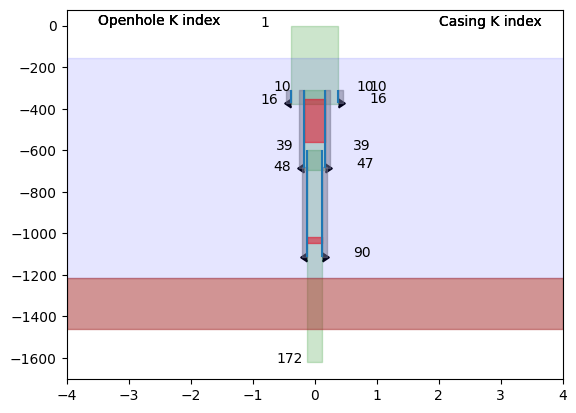

In [173]:
# 1. conductor casing
pipe_plotter (cond_Casing,
            LGR_depths,
            plt)
# 2. surface casing
pipe_plotter (surf_Casing,
            LGR_depths,
            plt)
# 3. production casing
pipe_plotter (prod_Casing,
            LGR_depths,
            plt)

# 4. barriers
for barrier in barriers:
    barrier_plotter(barrier,
                    plt)  

# 5. OB/reservoir
ob_reservoir_plotter(ref_depth1, ref_depth2, ref_depth3, plt)

plt.xlim(-4,4);


### Breakup of the plots

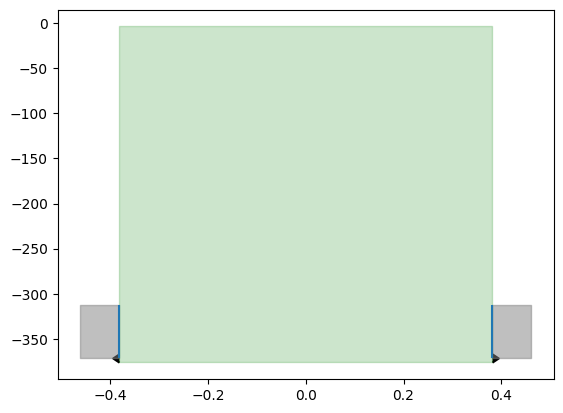

In [174]:
# conductor casing
pipe_plotter (cond_Casing,
            LGR_depths,
            plt)

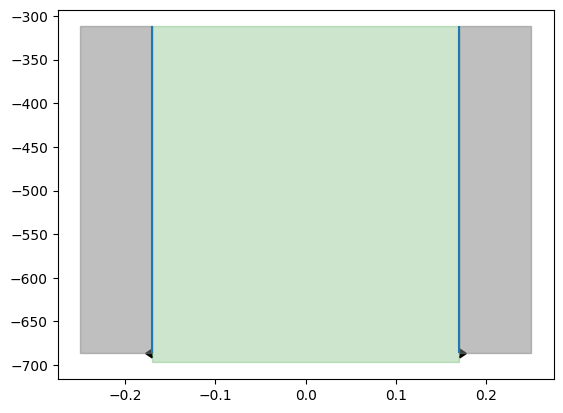

In [175]:
# surface casing
pipe_plotter (surf_Casing,
            LGR_depths,
            plt)

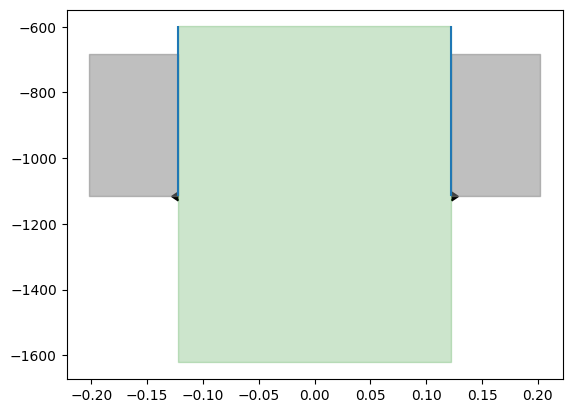

In [176]:
# production casing
pipe_plotter (prod_Casing,
            LGR_depths,
            plt)

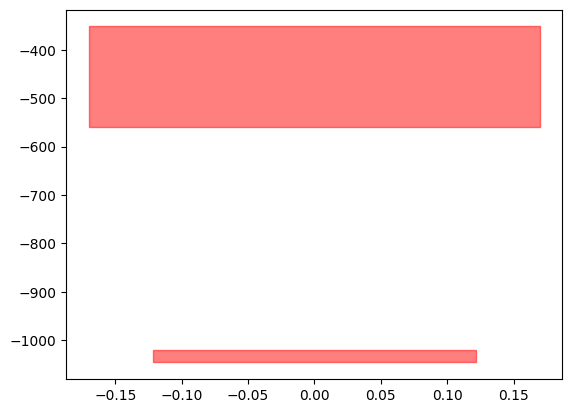

In [177]:
for barrier in barriers:
    barrier_plotter(barrier,
                    plt)  